Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
CSV file path: /kaggle/input/kannada-characters/kannada.csv
Image folder path: /kaggle/input/kannada-characters/Img
First few rows of the preprocessed CSV file:
              img  class
0  img001-001.png      1
1  img001-002.png      1
2  img001-003.png      1
3  img001-004.png      1
4  img001-005.png      1
Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Total images processed: 16425


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Learning rate:  0.001
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.0020 - loss: 8.8631 - val_accuracy: 0.0018 - val_loss: 12.1606 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 2/100
  1/102 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0078 - loss: 8.3135

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0078 - loss: 8.3135 - val_accuracy: 0.0015 - val_loss: 12.1541 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0076 - loss: 8.0753 - val_accuracy: 0.0015 - val_loss: 11.3822 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0156 - loss: 7.5815 - val_accuracy: 0.0015 - val_loss: 11.3356 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0177 - loss: 7.2776 - val_accuracy: 0.0012 - val_loss: 12.9927 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0312 - loss: 6.7809 - val_accuracy: 9.1324e-04 - val_loss: 12.9345 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0248 - loss: 6.6563 - val_accuracy: 9.1324e-04 - val_loss:

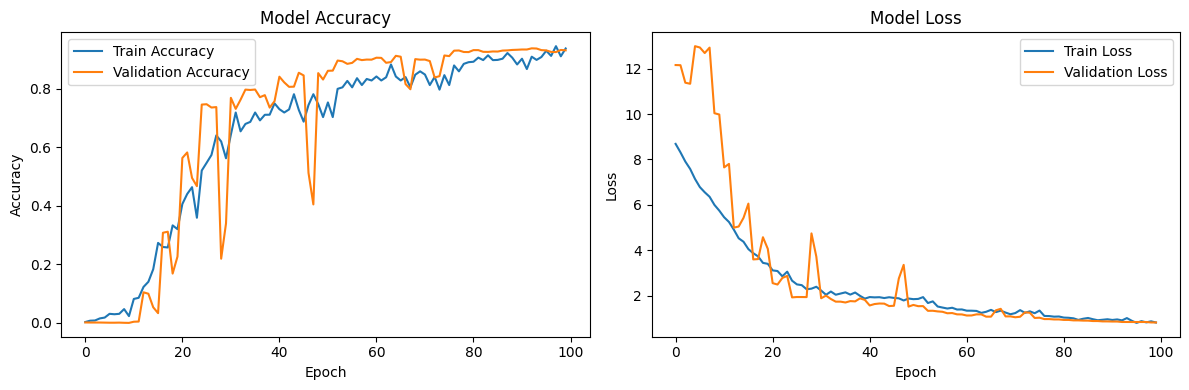

Model saved as 'kannada_ocr_model.h5'
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9361 - loss: 0.8130
Test accuracy: 0.9324


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2


# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Configure TensorFlow to use GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# 1. Segmentation (Lines, Words, Characters)
def segment_characters(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary_image = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv2.dilate(binary_image, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    characters = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        character = binary_image[y:y + h, x:x + w]
        characters.append(character)

    return characters

# 2. Ottakshara Segmentation
def separate_ottakshara(characters):
    ottakshara = []
    base_characters = []

    for char in characters:
        height, width = char.shape
        ottakshara_height_threshold = int(0.7 * height)
        base_part = char[:ottakshara_height_threshold, :]
        ottakshara_part = char[ottakshara_height_threshold:, :]

        base_characters.append(base_part)
        ottakshara.append(ottakshara_part)

    return base_characters, ottakshara

# 3. Preprocessing
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    norm_image = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)
    _, binary_image = cv2.threshold(norm_image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

# 4. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# 5. Loading and Preparing the Dataset
def preprocess_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['img'] = df['img'].str.replace('Img/', '', regex=False)
    print("First few rows of the preprocessed CSV file:")
    print(df.head())
    return df

def load_data(df, img_folder):
    images = []
    labels = []

    for index, row in df.iterrows():
        img_path = os.path.join(img_folder, row['img'])

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to read image: {img_path}")
            continue

        preprocessed_image = preprocess_image(image)
        resized_image = cv2.resize(preprocessed_image, (32, 32))
        images.append(resized_image)
        labels.append(row['class'])

        if index % 1000 == 0:
            print(f"Processed {index} images")

    if not images:
        raise ValueError("No valid images found. Check the image paths and file integrity.")

    print(f"Total images processed: {len(images)}")

    images = np.array(images).reshape(-1, 32, 32, 1) / 255.0
    labels = to_categorical(labels)

    return train_test_split(images, labels, test_size=0.2, random_state=42)
def build_cnn_model(num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 1), kernel_regularizer=l2(0.001)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten layer
        Flatten(),

        # Fully connected layers
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to create a learning rate schedule
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 75:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

def train_model():
    csv_path = '/kaggle/input/kannada-characters/kannada.csv'
    img_folder = '/kaggle/input/kannada-characters/Img'

    print(f"CSV file path: {csv_path}")
    print(f"Image folder path: {img_folder}")

    # Preprocess the CSV file
    df = preprocess_csv(csv_path)

    X_train, X_test, y_train, y_test = load_data(df, img_folder)

    num_classes = y_train.shape[1]
    model = build_cnn_model(num_classes)

    train_generator = datagen.flow(X_train, y_train, batch_size=128)

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


    history = model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 128,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the model
    model.save('/kaggle/working/kannada_ocr_model.h5')
    print("Model saved as 'kannada_ocr_model.h5'")

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")

if __name__ == "__main__":
    train_model()